## Setup Environment

In [1]:
LOCAL = True

# if run locally: 
if LOCAL:
    DATA_DIR = "../dataset"
    CODE_DIR = "../"
# on Colab
else:
    DATA_DIR = "/content"
    CODE_DIR = "."



In [2]:
import os, sys
ROOT = os.path.abspath(CODE_DIR)
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

If you want to use Claude Code, uncomment the cell below.

In [1]:
# !npm install -g @anthropic-ai/claude-code

If use Colab, you need to save output results to google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
storage_dir = "drive/MyDrive/Colab Notebooks/"

ModuleNotFoundError: No module named 'google'

We will work under the same dir as this notebook

To copy the code to fine-tune clip on tinyImageNet, run:

In [4]:
!git clone https://github.com/nbzy1995/clip_TinyImageNet.git

Cloning into 'clip_TinyImageNet'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 31 (delta 11), reused 31 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 125.90 KiB | 2.13 MiB/s, done.
Resolving deltas: 100% (11/11), done.


To download tiny imagenet dataset

In [ ]:
!wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-imagenet-200/val/images/val_1598.JPEG  
  inflating: tiny-ima

Now we created a directory called "tiny-imagenet-200" containing the dataset.


We now copy pre-computed index for the train/ folder, 90% for training, 10% for validation. The val/ folder will be used as test set.

In [ ]:
# if on Colab
!cp /content/clip_TinyImageNet/dataset/tiny_imagenet_90_idxs.npy /content/tiny_imagenet_90_idxs.npy

Now we install the requirements for fine-tuning clip on tinyImageNet

In [2]:
!pip install --quiet --upgrade pip
!pip install -q -r clip_TinyImageNet/requirements.txt
print("✅ Core packages installed!")

zsh:1: /Users/Yang/Desktop/model-merge/model-soups/clip_TinyImageNet/.venv/bin/pip: bad interpreter: /Users/Yang/Desktop/model-merge/model-soups/exp-clip_TinyImageNet/.venv/bin/python3: no such file or directory
zsh:1: /Users/Yang/Desktop/model-merge/model-soups/clip_TinyImageNet/.venv/bin/pip: bad interpreter: /Users/Yang/Desktop/model-merge/model-soups/exp-clip_TinyImageNet/.venv/bin/python3: no such file or directory
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'clip_TinyImageNet/requirements.txt'
✅ Core packages installed!


In [1]:
# Check GPU availability and system info
import torch
import subprocess

print("🔍 System Information:")
print(f"Python version: {subprocess.check_output(['python', '--version']).decode().strip()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("❌ No GPU available! Please enable GPU runtime in Colab.")
    print("Runtime > Change runtime type > Hardware accelerator > GPU")

🔍 System Information:
Python version: Python 3.11.5
PyTorch version: 2.8.0
CUDA available: False
❌ No GPU available! Please enable GPU runtime in Colab.
Runtime > Change runtime type > Hardware accelerator > GPU


## TinyImageNet - View

**First Time Setup:**
If the indices file doesn't exist, run the generation script ONCE:
```bash
cd dataset
python generate_train_val_indices.py
```

⚠️ **Do NOT run the generation script multiple times unless you want to change the split!**

In [7]:
# Check if persistent indices exist, generate if needed
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

sys.path.append(CODE_DIR)

INDICES_FILE = os.path.join(DATA_DIR, 'tiny_imagenet_train_val_indices.npy')

print("🔍 Checking for persistent indices...")

if os.path.exists(INDICES_FILE):
    print(f"✅ Found persistent indices: {INDICES_FILE}")
else:
    print(f"❌ Persistent indices not found: {INDICES_FILE}")




🔍 Checking for persistent indices...
✅ Found persistent indices: ../dataset/tiny_imagenet_train_val_indices.npy


In [8]:
print("Creating datasets...")

from dataset.tiny_imagenet import TinyImageNet

# Use CLIP's expected preprocessing for proper model evaluation
import clip
device = 'cuda' if torch.cuda.is_available() else 'cpu'
_, clip_preprocess = clip.load('ViT-B/32', device, jit=False)

data_tinyImageNet = TinyImageNet(
    train_preprocess=clip_preprocess,  # Use CLIP preprocessing for training
    eval_preprocess=clip_preprocess,   # Use CLIP preprocessing for evaluation
    location=DATA_DIR, 
    batch_size=8, 
    num_workers=2, 
    distributed=False,
)

print(f"✅ Datasets created:")
print(f"   Train split: {len(data_tinyImageNet.train_sampler)} samples") # Train split (90% of original train data)
print(f"   Val split: {len(data_tinyImageNet.val_sampler)} samples")
print(f"   Test split: {len(data_tinyImageNet.test_loader.dataset)} samples")

Creating datasets...
✅ Datasets created:
   Train split: 90000 samples
   Val split: 10000 samples
   Test split: 10000 samples


In [9]:
from itertools import islice

def show_split_samples(data, split_name, batch_index=0):
    """Show sample images with labels, indices, and paths"""

    if split_name == "train":
        loader = data.train_loader
    elif split_name == "validation":
        loader = data.val_loader
    elif split_name == "test":
        loader = data.test_loader

    # get one batch
    batch = next(islice(loader, batch_index, None))
    images = batch['images']
    labels = batch['labels']
    paths = batch['image_paths']
    print(f"fetching {len(labels)} samples")

    idx_to_class = data.idx_to_class

    # Create subplot
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(len(images)):
        # Display image (denormalize from CLIP preprocessing)
        img = images[i]
        # CLIP normalization: mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]
        mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
        std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
        img = img * std + mean  # denormalize
        img = torch.clamp(img, 0, 1)  # clamp to [0,1]
        img = img.permute(1, 2, 0)
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Get label info
        label_idx = int(labels[i])
        class_id = idx_to_class[label_idx]
        class_word = data.wordnet_map[class_id]

        # Show title with index and class
        axes[i].set_title(f"Label: {label_idx} | {class_id} | {class_word[:30]} \n Path: {os.path.basename(paths[i])}", fontsize=9)

    plt.tight_layout()
    plt.suptitle(f'{split_name.upper()} Split - Images with Labels', fontsize=14, y=1.02)
    plt.show()
    print()

Uncomment following cells to visualiza samples

In [8]:
# show_split_samples(data_tinyImageNet, "train",0)

In [9]:
# show_split_samples(data_tinyImageNet, "validation",6)

In [10]:
# show_split_samples(data_tinyImageNet, "test",0)

## Zero-shot classification

measure performance of CLIP zero-shot classifier on TinyImageNet dataset. use test split (val/ folder).

In [21]:
!python $CODE_DIR/zeroshot.py --dataset TinyImageNet --batch-size 32 --data-location $DATA_DIR

Building zero-shot classifier.
100%|█████████████████████████████████████████| 200/200 [02:10<00:00,  1.53it/s]
/Users/Yang/Desktop/model-merge/model-soups/clip_TinyImageNet/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
[0% 0/313]	Acc: 53.12	Data (t) 5.066	Batch (t) 5.571
[6% 20/313]	Acc: 57.59	Data (t) 0.001	Batch (t) 0.360
[13% 40/313]	Acc: 59.83	Data (t) 0.001	Batch (t) 0.342
^C
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x107058e00>
Traceback (most recent call last):
  File "/Users/Yang/Desktop/model-merge/model-soups/clip_TinyImageNet/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/Users/Yang/Desktop/model-merge/model-soups/clip_TinyImageNet/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader

## Fine-tuning
We start with pretrained CLIP ViT-B/32, then fine-tune it on TinyImageNet. The training set is 90% of the train/, and 10% of them are used as validation set. We sweep for different hyperparameters to create 5 diverse models for model soups.

### Hyperparameter Configurations:
1. **Config 1**: lr=3e-5, wd=0.1, epochs=10, batch_size=256, timm_aug=False
2. **Config 2**: lr=1e-5, wd=0.1, epochs=10, batch_size=256, timm_aug=False  
3. **Config 3**: lr=3e-6, wd=0.1, epochs=10, batch_size=256, timm_aug=False
4. **Config 4**: lr=2e-5, wd=1e-3, epochs=10, batch_size=256, timm_aug=True
5. **Config 5**: lr=1e-6, wd=1e-4, epochs=10, batch_size=256, timm_aug=False

In [ ]:
# Configuration 1: lr=3e-5, wd=0.1, epochs=10, batch_size=256, timm_aug=False
!python $CODE_DIR/finetune.py --lr 3e-5 --wd 0.1 --epochs 10 --batch-size 256 --data-location $DATA_DIR --name "config1"

# Backup model to Google Drive
!cp config1_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 1 completed and backed up to Drive!")

Building zero-shot classifier.
100%|█████████████████████████████████████████| 200/200 [02:30<00:00,  1.33it/s]
Saving model to ./config1_0.pt
/Users/Yang/Desktop/model-merge/model-soups/clip_TinyImageNet/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train Epoch: 0 [0% 0/352]	Loss: 1.527826	Data (t) 13.450	Batch (t) 47.732


In [ ]:
# Configuration 2: lr=1e-5, wd=0.1, epochs=10, batch_size=256, timm_aug=False
!python $CODE_DIR/finetune.py --lr 1e-5 --wd 0.1 --epochs 10 --batch-size 256 --data-location $DATA_DIR --name "config2"

# Backup model to Google Drive
!cp config2_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 2 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:10<00:00, 19.16it/s]
Saving model to ./config2_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 9.905963	Data (t) 10.999	Batch (t) 14.634
Train Epoch: 0 [6% 20/352]	Loss: 9.265083	Data (t) 1.937	Batch (t) 1.981
Train Epoch: 0 [11% 40/352]	Loss: 5.693511	Data (t) 1.926	Batch (t) 1.974
Train Epoch: 0 [17% 60/352]	Loss: 5.368682	Data (t) 1.717	Batch (t) 2.078
Train Epoch: 0 [23% 80/352]	Loss: 5.323544	Data (t) 1.932	Batch (t) 1.965
Train Epoch: 0 [28% 100/352]	Loss: 5.170714	Data (t) 1.935	Batch (t) 1.966
T

In [ ]:
# Configuration 3: lr=3e-6, wd=0.1, epochs=10, batch_size=256, timm_aug=False
!python $CODE_DIR/finetune.py --lr 3e-6 --wd 0.1 --epochs 10 --batch-size 256 --data-location $DATA_DIR --name "config3"

# Backup model to Google Drive
!cp config3_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 3 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:10<00:00, 18.65it/s]
Saving model to ./config3_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 10.080419	Data (t) 9.304	Batch (t) 13.214
Train Epoch: 0 [6% 20/352]	Loss: 9.975412	Data (t) 1.958	Batch (t) 1.999
Train Epoch: 0 [11% 40/352]	Loss: 8.800272	Data (t) 1.709	Batch (t) 1.741
Train Epoch: 0 [17% 60/352]	Loss: 6.325212	Data (t) 1.721	Batch (t) 1.752
Train Epoch: 0 [23% 80/352]	Loss: 5.486481	Data (t) 1.575	Batch (t) 1.605
Train Epoch: 0 [28% 100/352]	Loss: 5.370048	Data (t) 1.923	Batch (t) 1.954
T

In [ ]:
# Configuration 4: lr=2e-5, wd=1e-3, epochs=10, batch_size=256, timm_aug=True
!python $CODE_DIR/finetune.py --lr 2e-5 --wd 1e-3 --epochs 10 --batch-size 256 --timm-aug --data-location $DATA_DIR --name "config4"

# Backup model to Google Drive
!cp config4_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 4 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:10<00:00, 18.56it/s]
Saving model to ./config4_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 7.894632	Data (t) 18.065	Batch (t) 22.071
Train Epoch: 0 [6% 20/352]	Loss: 6.402021	Data (t) 1.958	Batch (t) 2.001
Train Epoch: 0 [11% 40/352]	Loss: 5.426595	Data (t) 1.923	Batch (t) 1.954
Train Epoch: 0 [17% 60/352]	Loss: 5.348491	Data (t) 1.937	Batch (t) 1.968
Train Epoch: 0 [23% 80/352]	Loss: 5.263780	Data (t) 1.918	Batch (t) 1.950
Train Epoch: 0 [28% 100/352]	Loss: 5.155759	Data (t) 1.927	Batch (t) 2.014
T

In [ ]:
# Configuration 5: lr=1e-6, wd=1e-4, epochs=10, batch_size=256, timm_aug=False
!python $CODE_DIR/finetune.py --lr 1e-6 --wd 1e-4 --epochs 10 --batch-size 256 --data-location $DATA_DIR --name "config5"

# Backup model to Google Drive
!cp config5_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 5 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:10<00:00, 18.89it/s]
Saving model to ./config5_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 10.025702	Data (t) 9.997	Batch (t) 14.122
Train Epoch: 0 [6% 20/352]	Loss: 10.150383	Data (t) 1.951	Batch (t) 1.982
Train Epoch: 0 [11% 40/352]	Loss: 9.481924	Data (t) 1.927	Batch (t) 1.958
Train Epoch: 0 [17% 60/352]	Loss: 9.420502	Data (t) 1.940	Batch (t) 1.971
Train Epoch: 0 [23% 80/352]	Loss: 7.933360	Data (t) 1.920	Batch (t) 1.952
Train Epoch: 0 [28% 100/352]	Loss: 6.353636	Data (t) 1.918	Batch (t) 1.966


## Load Individual Models
Load the models after training all 5 configurations, 

In [3]:
import torch
import clip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import tqdm
from utils import ModelWrapper,get_model_from_sd, eval_model_on_dataset

In [4]:
# Load all trained models (check both local and Drive backup)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_names = ['config1', 'config2', 'config3', 'config4', 'config5']
state_dicts = []

base_model, preprocess = clip.load('ViT-B/32', device, jit=False)
base_model = base_model.float() # Force the base model to stay in float32 to match saved weights

for name in model_names:
    # Load the final checkpoint (after 10 epochs)
    model_path = f'{name}_0.pt'
    drive_path = f'/content/drive/MyDrive/Colab Notebooks/{model_path}'

    # Try local first, then Drive backup
    if os.path.exists(model_path):
        print(f'Loading {model_path} (local)')
        state_dicts.append(torch.load(model_path, map_location=device))
    elif os.path.exists(drive_path):
        print(f'Loading {drive_path} (from Drive)')
        state_dicts.append(torch.load(drive_path, map_location=device))
    else:
        print(f'⚠️  Model {model_path} not found in local or Drive!')

print(f"✅ Loaded {len(state_dicts)} models successfully!")

# Also backup final soup results to Drive
def save_soup_results():
    import pickle
    results = {
        'individual_results': individual_results,
        'uniform_accuracy': uniform_accuracy,
        'greedy_accuracy': best_accuracy,
        'greedy_indices': greedy_indices,
        'model_configs': [
            'lr=3e-5, wd=0.1, timm_aug=False',
            'lr=1e-5, wd=0.1, timm_aug=False',
            'lr=3e-6, wd=0.1, timm_aug=False',
            'lr=2e-5, wd=1e-3, timm_aug=True',
            'lr=1e-6, wd=1e-4, timm_aug=False'
        ]
    }

    with open('/content/drive/MyDrive/Colab Notebooks/soup_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    print("💾 Soup results saved to Drive!")

Loading config1_0.pt (local)
⚠️  Model config2_0.pt not found in local or Drive!
⚠️  Model config3_0.pt not found in local or Drive!
⚠️  Model config4_0.pt not found in local or Drive!
⚠️  Model config5_0.pt not found in local or Drive!
✅ Loaded 1 models successfully!


### Diagnostic: uncomment to use
- evaluate on samples of the train, val, test split
- evaluate one model

In [10]:
# Choose one model idx
i = 0
print(f"\n🔍 Testing trained model {i} on training data sample...")

# Get number of classes from the dataset
num_classes = len(data_tinyImageNet.classnames)
debug_model = get_model_from_sd(state_dicts[i], base_model)


🔍 Testing trained model 0 on training data sample...


In [15]:
from itertools import islice

def show_split_samples_model_pred(model, data, split_name, batch_index=0):
    """Show sample images with label and model prediction"""

    if split_name == "train":
        loader = data.train_loader
    elif split_name == "validation":
        loader = data.val_loader
    elif split_name == "test":
        loader = data.test_loader

    # get one batch
    batch = next(islice(loader, batch_index, None))
    images = batch['images']
    labels = batch['labels']    
    print(f"fetching {len(labels)} samples")
    
    model.eval()
    with torch.no_grad():
        logits = model(images.to(device))
    pred = logits.argmax(dim=1, keepdim=True).cpu()
    print(f"pred: {pred.flatten()}")

    # Create subplot
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(len(images)):
        # Display image (denormalize from CLIP preprocessing)
        img = images[i]
        # CLIP normalization: mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]
        mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
        std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
        img = img * std + mean  # denormalize
        img = torch.clamp(img, 0, 1)  # clamp to [0,1]
        img = img.permute(1, 2, 0)
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Get label info
        pred_idx = int(pred[i])
        true_idx = int(labels[i])
        
        pred_class = data.idx_to_class[pred_idx]
        true_class = data.idx_to_class[true_idx]
        is_correct = (pred_idx == true_idx)

        color = 'green' if is_correct else 'red'
        axes[i].set_title(f"True: {data.wordnet_map[true_class][:20]}... \nPred: {data.wordnet_map[pred_class][:20]}...",
                         color=color, fontsize=10)

    plt.tight_layout()
    plt.suptitle(f'{split_name.upper()} Split - Images with Labels', fontsize=14, y=1.02)
    plt.show()
    print()

fetching 8 samples
pred: tensor([145,   1,  39, 192,  37, 142,  23, 123])


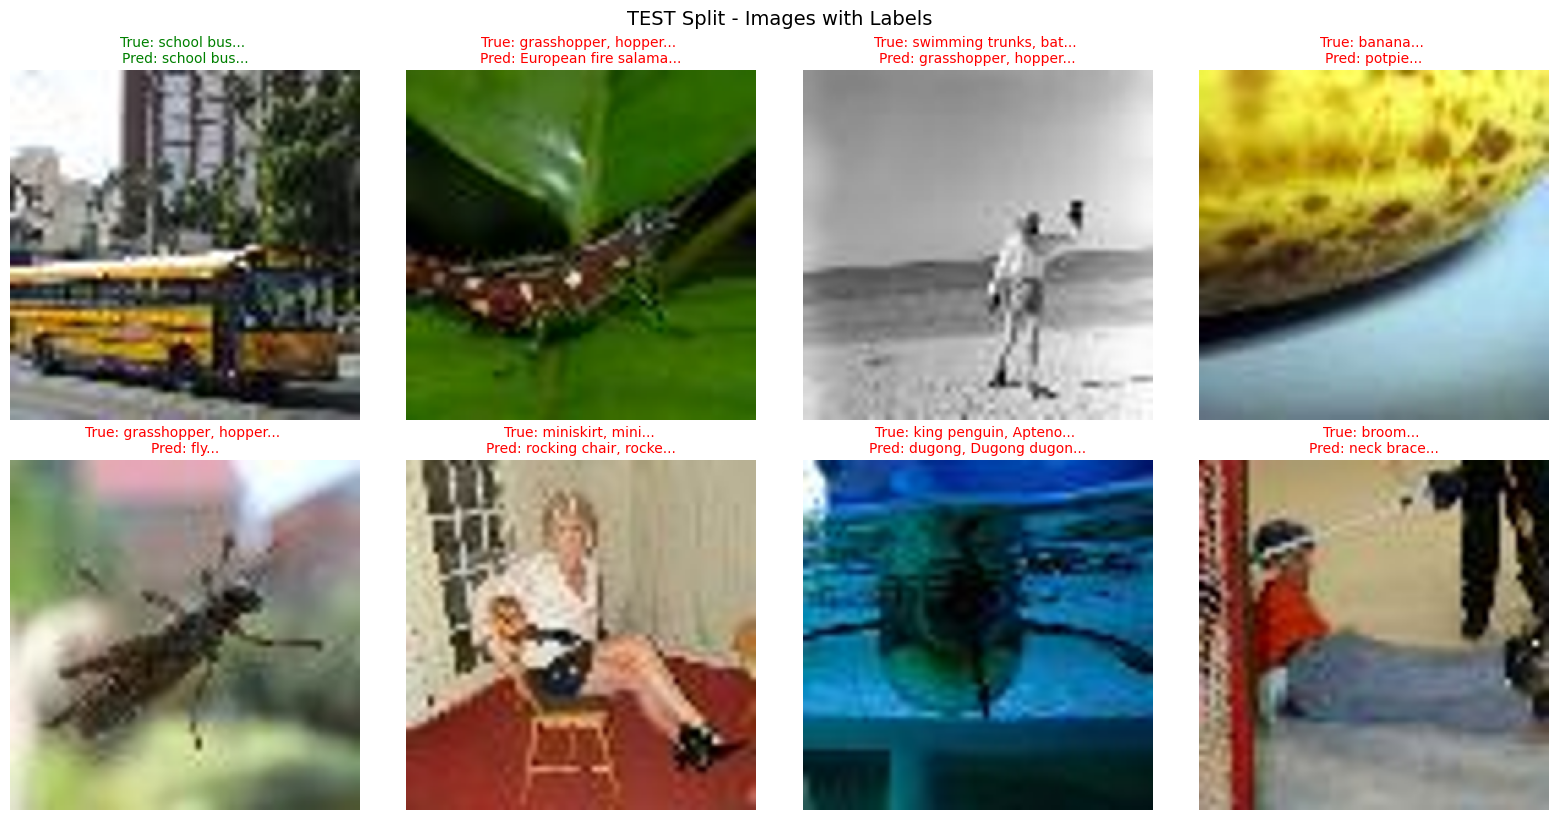

In [ ]:
# show_split_samples_model_pred(debug_model, data_tinyImageNet, "test",1)

### Evaluate individual models performance

In [ ]:
# Use the test dataset from our data object

test_dataset = data_tinyImageNet.test_dataset
test_loader = data_tinyImageNet.test_loader

num_classes = len(data_tinyImageNet.classnames)
individual_results = []

for i, state_dict in enumerate(state_dicts):
    print(f"\n📊 Evaluating Config {i+1}...")
    model = get_model_from_sd(state_dict, base_model)    
    accuracy = eval_model_on_dataset(model, test_loader)
    individual_results.append(accuracy)
    print(f"Config {i+1} Accuracy: {accuracy:.2f}%")

print(f"\n🎯 Individual Model Results:")
for i, acc in enumerate(individual_results):
    print(f"Config {i+1}: {acc:.2f}%")
print(f"Best Individual: {max(individual_results):.2f}%")


📊 Evaluating Config 1...


/Users/Yang/Desktop/model-merge/model-soups/clip_TinyImageNet/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[0% 0/1250]	Acc: 62.50	Data (t) 2.685	Batch (t) 2.796
[2% 20/1250]	Acc: 57.14	Data (t) 0.000	Batch (t) 0.099
[3% 40/1250]	Acc: 55.79	Data (t) 0.000	Batch (t) 0.097
[5% 60/1250]	Acc: 55.53	Data (t) 0.000	Batch (t) 0.101
[6% 80/1250]	Acc: 57.41	Data (t) 0.000	Batch (t) 0.102
[8% 100/1250]	Acc: 58.42	Data (t) 0.000	Batch (t) 0.099
[10% 120/1250]	Acc: 58.88	Data (t) 0.000	Batch (t) 0.097
[11% 140/1250]	Acc: 59.22	Data (t) 0.000	Batch (t) 0.099
[13% 160/1250]	Acc: 59.70	Data (t) 0.000	Batch (t) 0.099
[14% 180/1250]	Acc: 59.74	Data (t) 0.000	Batch (t) 0.097
[16% 200/1250]	Acc: 59.89	Data (t) 0.000	Batch (t) 0.105
[18% 220/1250]	Acc: 59.84	Data (t) 0.001	Batch (t) 0.104
[19% 240/1250]	Acc: 59.65	Data (t) 0.001	Batch (t) 0.106
[21% 260/1250]	Acc: 59.91	Data (t) 0.001	Batch (t) 0.100
[22% 280/1250]	Acc: 60.45	Data (t) 0.000	Batch (t) 0.102
[24% 300/1250]	Acc: 60.47	Data (t) 0.001	Batch (t) 0.098
[26% 320/1250]	Acc: 60.51	Data (t) 0.001	Batch (t) 0.102
[27% 340/1250]	Acc: 60.26	Data (t) 0.000	Ba

KeyboardInterrupt: 

## Model Soup
Create and evaluate uniform and greedy model soups

In [ ]:
def create_soup(state_dicts, weights=None):
    """Create a model soup by averaging state dicts with given weights"""
    if weights is None:
        weights = [1.0 / len(state_dicts)] * len(state_dicts)

    # Start with the first model weighted
    soup_state_dict = {k: v.clone() * weights[0] for k, v in state_dicts[0].items()}

    # Add remaining models
    for i, state_dict in enumerate(state_dicts[1:], 1):
        for k, v in state_dict.items():
            soup_state_dict[k] += v.clone() * weights[i]

    return soup_state_dict

In [ ]:
# Create and evaluate uniform soup (simple average)
print("🍲 Creating Uniform Soup...")
uniform_soup_state = create_soup(state_dicts)
uniform_soup_model = get_model_from_sd(uniform_soup_state, base_model)
uniform_accuracy = evaluate_model(uniform_soup_model, test_loader)

print(f"\n🍲 Uniform Soup Accuracy: {uniform_accuracy:.2f}%")
print(f"Improvement over best individual: {uniform_accuracy - max(individual_results):.2f}%")

# Simple greedy soup implementation (add models if they improve performance)
print(f"\n🧠 Creating Greedy Soup...")
best_accuracy = 0
best_state_dict = None
greedy_indices = []

# Start with the best individual model
best_idx = np.argmax(individual_results)
greedy_indices.append(best_idx)
best_state_dict = state_dicts[best_idx]
best_accuracy = individual_results[best_idx]

print(f"Starting with Config {best_idx + 1} (accuracy: {best_accuracy:.2f}%)")

# Try adding each remaining model
for i, state_dict in enumerate(state_dicts):
    if i == best_idx:
        continue

    # Create soup with current best + this model
    temp_soup = create_soup([best_state_dict, state_dict])
    temp_model = get_model_from_sd(temp_soup, base_model)
    temp_accuracy = evaluate_model(temp_model, test_loader)

    print(f"Adding Config {i+1}: {temp_accuracy:.2f}%")

    if temp_accuracy > best_accuracy:
        print(f"✅ Improved! Adding Config {i+1}")
        greedy_indices.append(i)
        best_state_dict = temp_soup
        best_accuracy = temp_accuracy
    else:
        print(f"❌ No improvement, skipping Config {i+1}")

print(f"\n🧠 Greedy Soup includes configs: {[i+1 for i in greedy_indices]}")
print(f"🧠 Greedy Soup Accuracy: {best_accuracy:.2f}%")
print(f"Improvement over best individual: {best_accuracy - max(individual_results):.2f}%")

📊 Summary Results:
         Method  Accuracy (%)
       Config 1          0.13
       Config 2          0.14
       Config 3          0.27
       Config 4          0.09
       Config 5          0.39
Best Individual          0.39
   Uniform Soup          5.50
    Greedy Soup         10.30


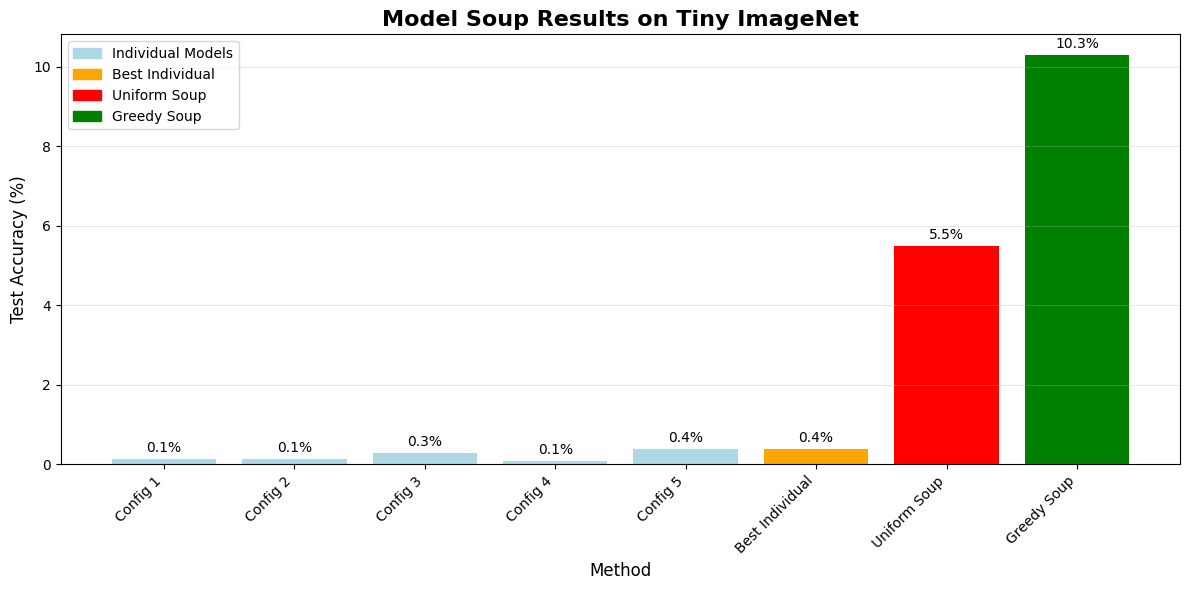


🎉 Final Results Summary:
Zero-shot CLIP: ~61.39% (from earlier)
Best Individual Model: 0.39%
Uniform Soup: 5.50% (+5.11%)
Greedy Soup: 10.30% (+9.91%)

✨ Model soups successfully improved over the best individual model!


In [46]:
# Create summary results
results_summary = {
    'Method': ['Config 1', 'Config 2', 'Config 3', 'Config 4', 'Config 5',
               'Best Individual', 'Uniform Soup', 'Greedy Soup'],
    'Accuracy (%)': individual_results + [max(individual_results), uniform_accuracy, best_accuracy]
}

# Create DataFrame for easy visualization
results_df = pd.DataFrame(results_summary)
print("📊 Summary Results:")
print(results_df.to_string(index=False))

# Plot results
plt.figure(figsize=(12, 6))
colors = ['lightblue'] * 5 + ['orange', 'red', 'green']
bars = plt.bar(results_df['Method'], results_df['Accuracy (%)'], color=colors)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom')

plt.title('Model Soup Results on Tiny ImageNet', fontsize=16, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.xlabel('Method', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, color='lightblue', label='Individual Models'),
                   plt.Rectangle((0,0),1,1, color='orange', label='Best Individual'),
                   plt.Rectangle((0,0),1,1, color='red', label='Uniform Soup'),
                   plt.Rectangle((0,0),1,1, color='green', label='Greedy Soup')]
plt.legend(handles=legend_elements, loc='upper left')

plt.show()

# Print final summary
print(f"\n🎉 Final Results Summary:")
print(f"Zero-shot CLIP: ~61.39% (from earlier)")
print(f"Best Individual Model: {max(individual_results):.2f}%")
print(f"Uniform Soup: {uniform_accuracy:.2f}% (+{uniform_accuracy - max(individual_results):.2f}%)")
print(f"Greedy Soup: {best_accuracy:.2f}% (+{best_accuracy - max(individual_results):.2f}%)")
print(f"\n✨ Model soups successfully improved over the best individual model!")